# Logistic Regression From Scratch

In [111]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use("dark_background")
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix


# types: for better functions
from numpy.typing import NDArray
from typing import Any

## Implementation Code

In [120]:
class LogisticRegression:
    """implement logistic regression from scratch"""

    def __init__(
        self, learning_rate: float = 0.001, epochs: int = 500, classes: int = 2
    ) -> None:
        # initializing model & hyper parameters
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.no_of_classes = classes
        self.bias = None
        self.weight = None

    def linear_equation(
        self, x: NDArray[np.float64], w: NDArray[np.float64], b: float | NDArray
    ) -> NDArray:
        # equation: z = w . x + b
        if x.shape[1] != w.shape[0]:
            raise ValueError("X and W are mismatched column count")

        return np.dot(x, w) + b

    @staticmethod
    def sigmoid(z: NDArray) -> NDArray:
        # equation: sigmoid(z) = 1 / 1 + e ^ -z
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def softmax(z: NDArray[float]) -> NDArray:
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / exp_z.sum(axis=1, keepdims=True)

    def get_dw(
        self, y_true: NDArray[int], y_prob: NDArray[float], x: NDArray[float]
    ) -> float:

        # equation: dw = 1/n . y_prob_i - y_true_i . x_i
        if self.no_of_classes > 2:
            result = []
            for yp_i, y_i, x_i in zip(y_prob, y_true, x):
                error = np.array(yp_i) - np.array(y_i)
                result.append(np.outer(error, x_i))
            return np.mean(result)

        error = y_prob - y_true
        dw = []
        for each in x.T:
            result = np.mean([np.round(a * b, 3) for a, b in zip(error, each)])
            dw.append(result)
        return np.array(dw)

    @staticmethod
    def get_db(y_true: NDArray[float], y_prob: NDArray[float]) -> float:
        error = y_prob - y_true
        return np.mean(error, axis=0)

    def update_params(
        self, y_prob: NDArray, y_true: NDArray, x: NDArray
    ) -> tuple[float, float]:
        # @Returns: (weight, bias)
        new_weight = self.weight - (
            self.learning_rate * self.get_dw(y_prob=y_prob, y_true=y_true, x=x)
        )
        new_bias = self.bias - (
            self.learning_rate * self.get_db(y_prob=y_prob, y_true=y_true)
        )
        return (new_weight, new_bias)

    def forward_prop(self, x: NDArray) -> Any:
        logits = self.linear_equation(x=x, w=self.weight, b=self.bias)
        return self.softmax(logits) if self.no_of_classes > 2 else self.sigmoid(logits)

    def backward_prop(self, y_prob: NDArray, y_true: NDArray, x: NDArray) -> Any:
        self.weight, self.bias = self.update_params(y_prob=y_prob, y_true=y_true, x=x)

    def fit(self, x: NDArray[np.float64], y: NDArray[np.int16]) -> Any:

        self.weight = (
            np.random.randn(x.shape[1]) * 0.01
            if self.no_of_classes <= 2
            else np.random.randn(x.shape[1], self.no_of_classes) * 0.01
        )
        self.bias = 0 if self.no_of_classes <= 2 else np.zeros(self.no_of_classes)

        for _ in range(self.epochs):
            prob = self.forward_prop(x=x)
            self.backward_prop(x=x, y_prob=prob, y_true=y)

        print("training completed")

    def predict(self, x: np.ndarray) -> Any:
        pred_logits = self.linear_equation(x=x, w=self.weight, b=self.bias)

        if self.no_of_classes > 2:
            pred_prob = self.softmax(pred_logits)
            prediction = []
            for each in pred_prob:
                mx_value = max(each)
                rows = [1 if i == mx_value else 0 for i in each]
                prediction.append(rows)
            return np.array(prediction)

        pred_prob = self.sigmoid(pred_logits)
        return np.array(list(map(lambda x: 1 if x > 0.5 else 0, pred_prob)))   # map probability into 1,0

## Binary Class Classification

In [121]:
bin_raw_x, bin_raw_y = make_classification(
    n_features=10, n_samples=1000, random_state=3442
)

In [122]:
print(f"Shape of binary classification data: {bin_raw_x.shape, bin_raw_y.shape}")

Shape of binary classification data: ((1000, 10), (1000,))


In [123]:
x_train, x_test, y_train, y_test = train_test_split(
    bin_raw_x, bin_raw_y, random_state=3453, test_size=0.2
)
(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((800, 10), (800,)), ((200, 10), (200,)))

In [124]:
b_model = LogisticRegression()

b_model.fit(x=x_train, y=y_train)

training completed


In [125]:
y_pred = b_model.predict(x=x_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
cm_values = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp

(np.int64(103), np.int64(3), np.int64(10), np.int64(84))

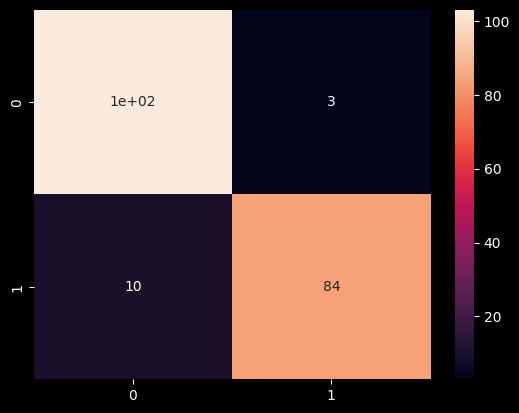

In [126]:
sns.heatmap(cm_values, annot=True)
plt.show()

In [127]:
test_acc = accuracy_score(y_test, y_pred) * 100    # test accuracy

y_pred_train = b_model.predict(x_train)
train_acc = accuracy_score(y_train, y_pred_train) * 100   # train accuracy

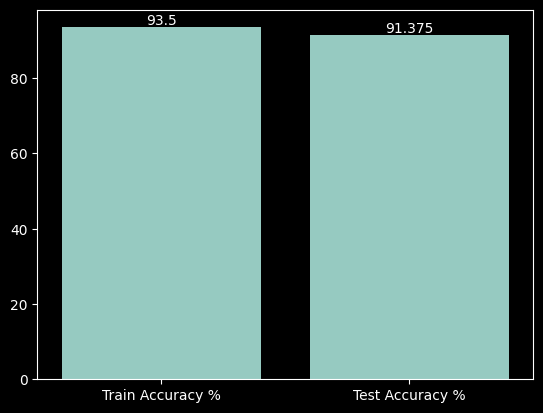

In [128]:
ax = sns.barplot([test_acc, train_acc])
for i in ax.containers:
    ax.bar_label(i)
plt.xticks([0,1], ["Train Accuracy %", "Test Accuracy %"])
plt.show()

## Multi Class Classification

In [129]:
multi_raw_x, multi_raw_y = make_classification(
    n_features=10, n_samples=1000, random_state=3442, n_classes=4, n_informative=4
)

In [130]:
print(
    f"Shape of multiclass classification data: {multi_raw_x.shape, multi_raw_y.shape}"
)

Shape of multiclass classification data: ((1000, 10), (1000,))


In [131]:
# encode the target varibale with one-hot encoding 
# e.g. [0,1] => [[1,0], [0, 1]]

oe = OneHotEncoder()
value = oe.fit_transform(multi_raw_y.reshape(-1, 1))
encoded_y = value.toarray()
encoded_y[:3]

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [151]:
mx_train, mx_test, my_train, my_test = train_test_split(
    multi_raw_x, encoded_y, random_state=3453, test_size=0.2
)
(mx_train.shape, my_train.shape), (mx_test.shape, my_test.shape)

(((800, 10), (800, 4)), ((200, 10), (200, 4)))

In [152]:
m_model = LogisticRegression(classes=4)
m_model.fit(mx_train, my_train)

training completed


In [160]:
y_pred = m_model.predict(mx_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(my_test, axis=1)

test_acc = accuracy_score(y_test, y_pred)

y_pred = m_model.predict(mx_train)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(my_train, axis=1)

train_acc = accuracy_score(y_test, y_pred)

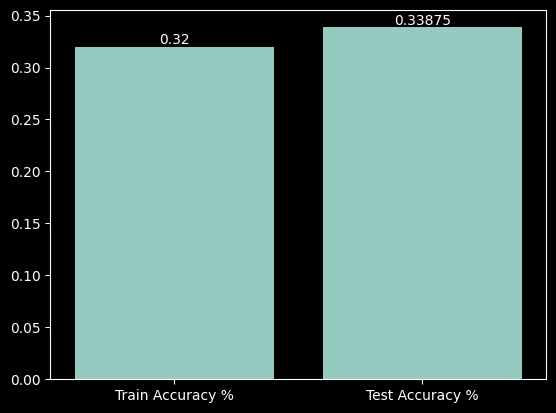

In [159]:
ax = sns.barplot([test_acc, train_acc])
for i in ax.containers:
    ax.bar_label(i)
plt.xticks([0,1], ["Train Accuracy %", "Test Accuracy %"])
plt.show()